# Resnet 34

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim


In [3]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.10.0+cu111


In [4]:
!pip install xmltodict

In [5]:
import xmltodict

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/content/drive/MyDrive/CV/FaceMaskDetection'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [9]:
path_annotations="/content/drive/MyDrive/CV/FaceMaskDetection/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'without_mask', 'mask_weared_incorrect']) 
 dict_values([3232, 717, 123])


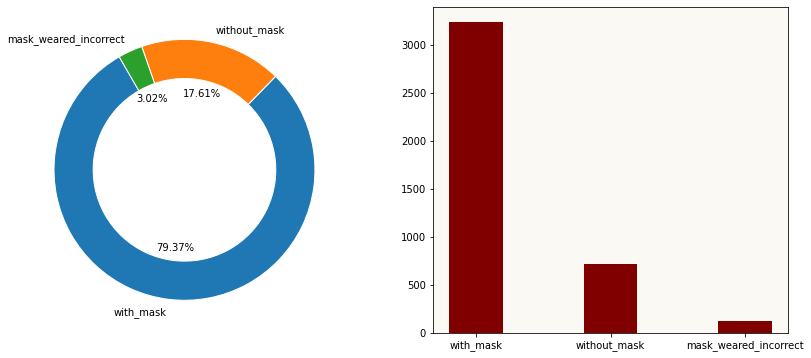

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

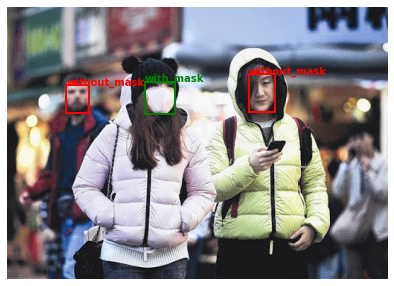

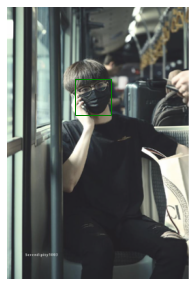

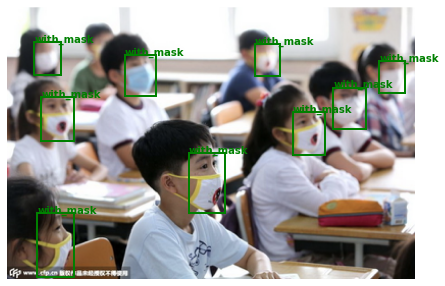

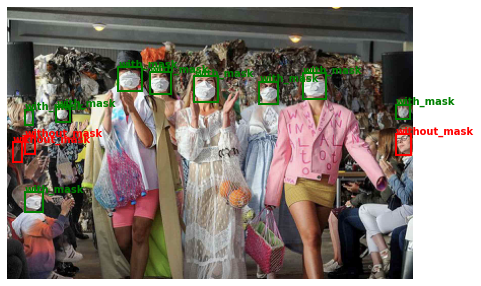

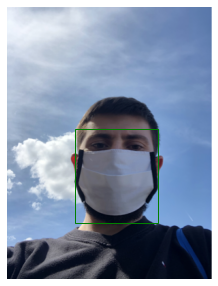

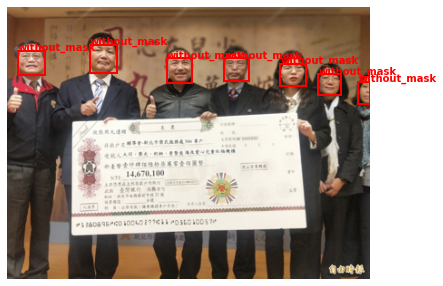

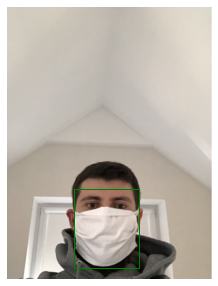

In [12]:
path_image="/content/drive/MyDrive/CV/FaceMaskDetection/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

In [14]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [15]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

In [16]:
mydataset[0]

[tensor([[[0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          [0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          [0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941],
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941],
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941]],
 
         [[0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          [0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          [0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255],
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255],
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255]],
 
         [[0.3098, 0.3098, 0.3098,  ..., 0.2941, 0.2941, 0.2941],
          [0.3098, 0.3098, 0.3098,  ..., 0.2941, 0.2941, 0.2941],
          [0.3098, 0.3098, 0.3098,  ...,

In [17]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [18]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

In [19]:
train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [21]:
import sys
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


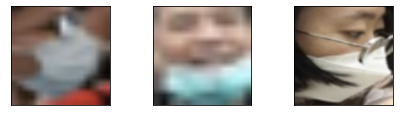

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

In [23]:
model=models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [24]:
for param in model.parameters():
    param.requires_grad=False

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

reinitialize model with output features as 3 : Linear(in_features=512, out_features=3, bias=True)


In [27]:
features_resnet34 = []
for key,value in model._modules.items():
    features_resnet34.append(value)

features_resnet34

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [29]:
conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param)

 Number of Parameters for conv2D is : 73728


In [30]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)


In [31]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [32]:
#n_epochs=1

for epoch in range(1,2): 
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
    

print('\nFinished Training')

Epoch 1, batch 20, training loss 0.4546844005584717
Epoch 1, batch 40, training loss 0.46240973472595215
Epoch 1, batch 60, training loss 0.45241894721984866
Epoch 1, batch 80, training loss 0.452410888671875

Finished Training


# Resnet 50

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim


In [2]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.10.0+cu111


In [3]:
!pip install xmltodict

In [4]:
import xmltodict

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/content/drive/MyDrive/CV_Assignment_2/archive (3)'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [11]:
path_annotations="/content/drive/MyDrive/CV_Assignment_2/archive (3)/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'without_mask', 'mask_weared_incorrect']) 
 dict_values([3232, 717, 123])


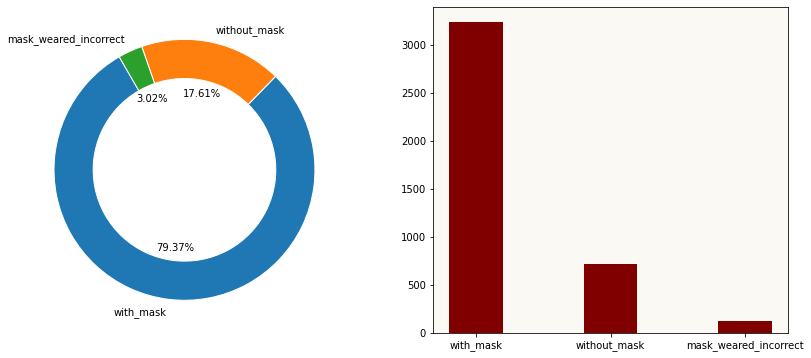

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

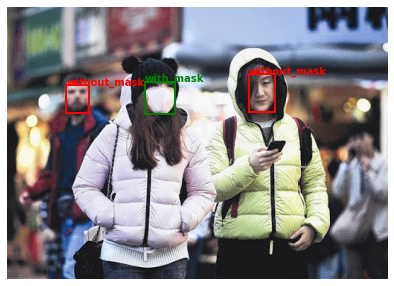

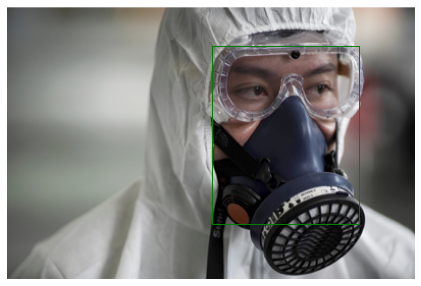

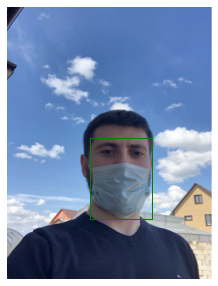

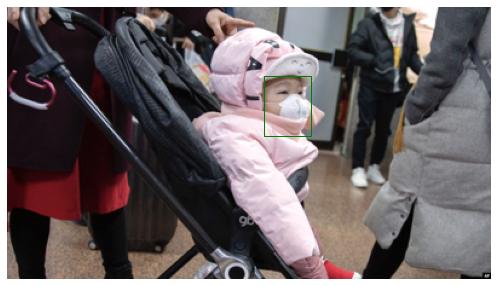

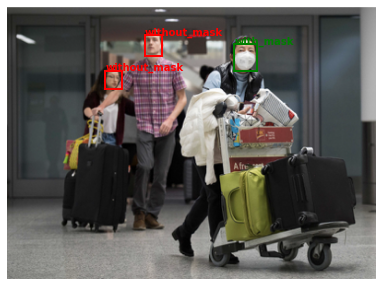

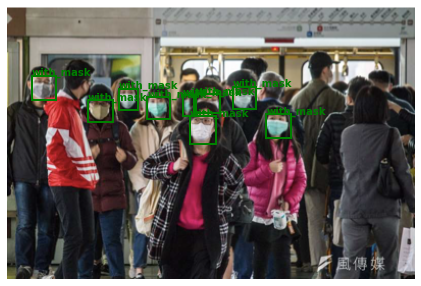

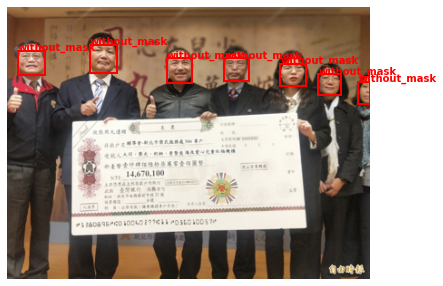

In [13]:
path_image="/content/drive/MyDrive/CV_Assignment_2/archive (3)/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

In [14]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [15]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

In [16]:
mydataset[0]

[tensor([[[0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          [0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          [0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941],
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941],
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941]],
 
         [[0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          [0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          [0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255],
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255],
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255]],
 
         [[0.3098, 0.3098, 0.3098,  ..., 0.2941, 0.2941, 0.2941],
          [0.3098, 0.3098, 0.3098,  ..., 0.2941, 0.2941, 0.2941],
          [0.3098, 0.3098, 0.3098,  ...,

In [17]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [18]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

In [19]:
train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [21]:
import sys
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


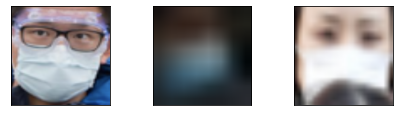

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

In [23]:
model=models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [24]:
for param in model.parameters():
    param.requires_grad=False

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

reinitialize model with output features as 3 : Linear(in_features=2048, out_features=3, bias=True)


In [27]:
features_resnet50 = []
for key,value in model._modules.items():
    features_resnet50.append(value)

features_resnet50

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [28]:
conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param)

 Number of Parameters for conv2D is : 73728


In [29]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)


In [30]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [31]:
#n_epochs=1

for epoch in range(1,2): 
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
    

print('\nFinished Training')

Epoch 1, batch 20, training loss 0.44643511772155764
Epoch 1, batch 40, training loss 0.42833819389343264
Epoch 1, batch 60, training loss 0.4430265426635742
Epoch 1, batch 80, training loss 0.4325752258300781

Finished Training


# Resnet 152

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os

import torch
from torchvision import datasets,transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image

import sys
import torch.optim as optim


In [2]:
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.10.0+cu111


In [3]:
!pip install xmltodict

In [4]:
import xmltodict

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
img_names=[] 
xml_names=[] 
for dirname, _, filenames in os.walk('/content/drive/MyDrive/CV_Assignment_2/archive (3)'):
    for filename in filenames:
        if os.path.join(dirname, filename)[-3:]!="xml":
            img_names.append(filename)
        else:
            xml_names.append(filename)

In [11]:
path_annotations="/content/drive/MyDrive/CV_Assignment_2/archive (3)/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()
print(Items,'\n',values)

dict_keys(['with_mask', 'without_mask', 'mask_weared_incorrect']) 
 dict_values([3232, 717, 123])


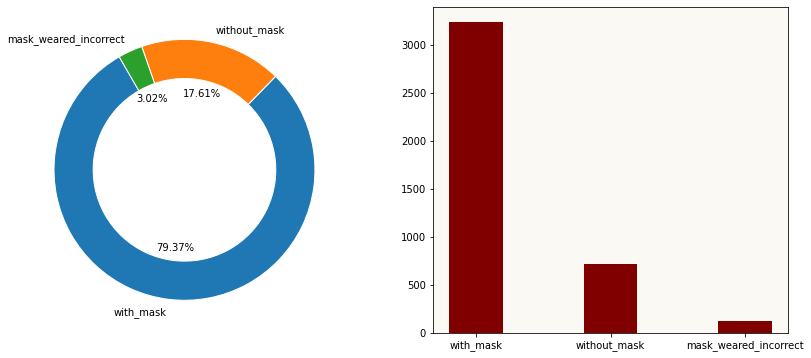

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

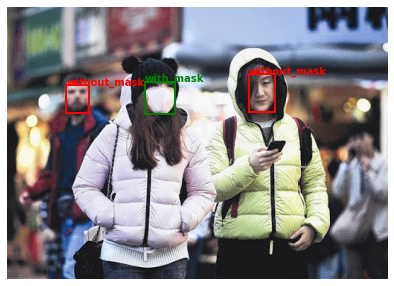

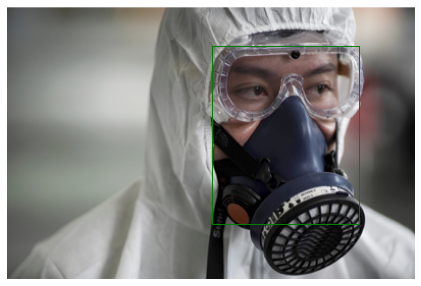

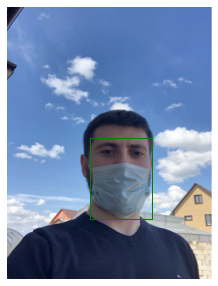

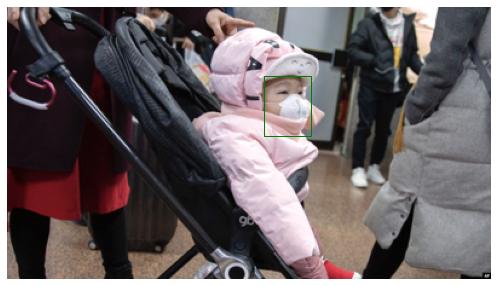

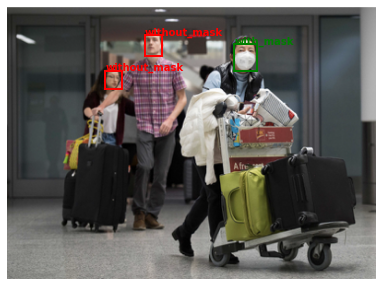

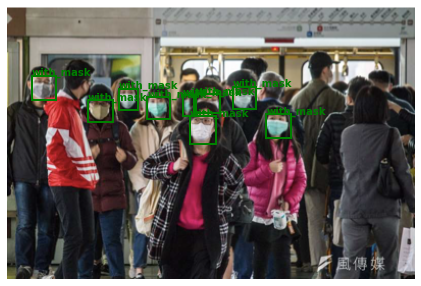

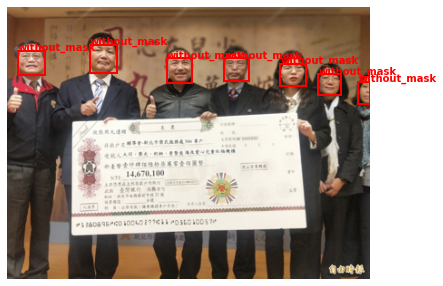

In [13]:
path_image="/content/drive/MyDrive/CV_Assignment_2/archive (3)/images/"  
def face_cas(img): 
    with open(path_annotations+img[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    image=plt.imread(os.path.join(path_image+img))
    fig,ax=plt.subplots(1)
    ax.axis("off")
    fig.set_size_inches(10,5)
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            ###with_mask
            if temp[i]["name"]=="with_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='g',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("with_mask", (rx, ry), color='green', weight='bold', fontsize=10, ha='left', va='baseline')
            ###without_mask
            if temp[i]["name"]=="without_mask":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))     
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='r',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("without_mask", (rx, ry), color='red', weight='bold', fontsize=10, ha='left', va='baseline')
            ###mask_weared_incorrect
            if temp[i]["name"]=="mask_weared_incorrect":
                x,y,w,h=list(map(int,temp[i]["bndbox"].values()))
                mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor='y',facecolor="none",lw=2,)
                ax.add_patch(mpatch)
                rx, ry = mpatch.get_xy()
                ax.annotate("mask_weared_incorrect", (rx, ry), color='yellow', weight='bold', fontsize=10, ha='left', va='baseline')
    else:
        x,y,w,h=list(map(int,temp["bndbox"].values()))
        edgecolor={"with_mask":"g","without_mask":"r","mask_weared_incorrect":"y"}
        mpatch=mpatches.Rectangle((x,y),w-x,h-y,linewidth=1, edgecolor=edgecolor[temp["name"]],facecolor="none",)
    ax.imshow(image)
    ax.add_patch(mpatch)

fun_images = img_names.copy()
for i in range(1,8):
    face_cas(fun_images[i])

In [14]:
options={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2} 

In [15]:
def dataset_creation(image_list): 
    image_tensor=[]
    label_tensor=[]
    for i,j in enumerate(image_list):
        with open(path_annotations+j[:-4]+".xml") as fd:
            doc=xmltodict.parse(fd.read())
        if type(doc["annotation"]["object"])!=list:
            temp=doc["annotation"]["object"]
            x,y,w,h=list(map(int,temp["bndbox"].values()))
            label=options[temp["name"]]
            image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"), y,x,h-y,w-x)
            image_tensor.append(my_transform(image))
            label_tensor.append(torch.tensor(label))
        else:
            temp=doc["annotation"]["object"]
            for k in range(len(temp)):
                x,y,w,h=list(map(int,temp[k]["bndbox"].values()))
                label=options[temp[k]["name"]]
                image=transforms.functional.crop(Image.open(path_image+j).convert("RGB"),y,x,h-y,w-x)
                image_tensor.append(my_transform(image))
                label_tensor.append(torch.tensor(label))
                
    final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
    return tuple(final_dataset)


my_transform=transforms.Compose([transforms.Resize((226,226)),
                                 transforms.ToTensor()])

mydataset=dataset_creation(img_names)

In [16]:
mydataset[0]

[tensor([[[0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          [0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          [0.2980, 0.2980, 0.2980,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941],
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941],
          [0.7529, 0.7529, 0.7529,  ..., 0.6941, 0.6941, 0.6941]],
 
         [[0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          [0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          [0.3059, 0.3059, 0.3059,  ..., 0.2745, 0.2745, 0.2745],
          ...,
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255],
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255],
          [0.6353, 0.6353, 0.6353,  ..., 0.7255, 0.7255, 0.7255]],
 
         [[0.3098, 0.3098, 0.3098,  ..., 0.2941, 0.2941, 0.2941],
          [0.3098, 0.3098, 0.3098,  ..., 0.2941, 0.2941, 0.2941],
          [0.3098, 0.3098, 0.3098,  ...,

In [17]:
train_size=int(len(mydataset)*0.7)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 4072 
Length of training set is : 2850 
Length of test set is : 1222


In [18]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

In [19]:
train_dataloader =DataLoader(dataset=trainset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader =DataLoader(dataset=testset,batch_size=32,shuffle=True,num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available()
                               else "cpu")

In [21]:
import sys
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Feature batch shape: torch.Size([32, 3, 226, 226])
Labels batch shape: torch.Size([32])


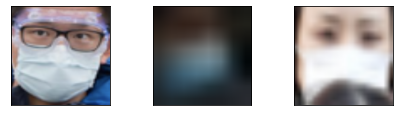

In [22]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    
train_features_np=train_features.numpy()

fig=plt.figure(figsize=(25,4))
for idx in np.arange(3):
    ax=fig.add_subplot(2,20/2,idx+1,xticks=[],yticks=[])
    plt.imshow(np.transpose(train_features_np[idx],(1,2,0)))

In [23]:
model=models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [24]:
for param in model.parameters():
    param.requires_grad=False

In [25]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
import torch.nn as nn
n_inputs=model.fc.in_features
last_layer=nn.Linear(n_inputs,3)

model.fc.out_features=last_layer
print('reinitialize model with output features as 3 :', model.fc.out_features)

reinitialize model with output features as 3 : Linear(in_features=2048, out_features=3, bias=True)


In [27]:
features_resnet152 = []
for key,value in model._modules.items():
    features_resnet152.append(value)

features_resnet152

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [28]:
conv_param = 64 * 128 * 3 * 3
print(' Number of Parameters for conv2D is :', conv_param)

 Number of Parameters for conv2D is : 73728


In [29]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)


In [30]:
param.requires_grad=True
ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

In [31]:
#n_epochs=1

for epoch in range(1,2): 
    running_loss = 0.0
    train_losses = []
    for i, (inputs, labels) in enumerate(train_dataloader):
        
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()
        
        #inputs = inputs.to(device)
        #labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() 
        if i % 20 == 19:    
                
                print("Epoch {}, batch {}, training loss {}".format(epoch, i+1,running_loss/20))
        
        running_loss = 0.0
     
    

print('\nFinished Training')

Epoch 1, batch 20, training loss 0.44643511772155764
Epoch 1, batch 40, training loss 0.42833819389343264
Epoch 1, batch 60, training loss 0.4430265426635742
Epoch 1, batch 80, training loss 0.4325752258300781

Finished Training


# CNN

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree


In [ ]:
annotations_directory = '../input/face-mask-detection/annotations'
images_directory = '../input/face-mask-detection/images'

In [ ]:

information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [ ]:
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

In [ ]:
# Add Annotation and Image File Names
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'

# Tidy Grammatical Issue
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

In [ ]:
annotations_info_df

In [ ]:
def render_image(image_path):
    image = cv2.imread(image_path)
    img=image_path.split('/')[-1]
    #print(image.shape)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
        (x,y,width,height)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                        annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
        bound_box.append((x,y,width,height))  
        if annotations_info_df.loc[i].label=='with_mask':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 200, 0), 2)
            cv2.putText(image, org = (x-8 , y-8), text = "Mask", 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (0, 200, 0))
        elif annotations_info_df.loc[i].label=='mask_incorrectly_worn':
            cv2.rectangle(image, (x,y), (x+width, y+height), (255, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Incorrect', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        else:
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'No mask', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (200, 0, 0))
        
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    
    return bound_box,image

In [ ]:
images_with_2=[]
for _ in annotations_info_df['image_file'].value_counts().index:
    if annotations_info_df[annotations_info_df['image_file']==_].shape[0]==2:
        images_with_2.append(_)

In [ ]:
len(images_with_2)

In [ ]:
annotations_info_df.loc[0]

In [ ]:
annotations_info_df

In [ ]:
for i in images_with_2[:3]:
    render_image(os.path.join(images_directory,i))



In [ ]:

bound_box,image=render_image(os.path.join(images_directory,i))

In [ ]:
for i in bound_box:
    cropped = image[i[1]:i[3],i[0]:i[2]]
    plt.imshow(cropped)
    plt.show()

In [ ]:
directory = 'cropped_images'
parent_directory = '/kaggle/working'
path = os.path.join(parent_directory, directory)
os.mkdir(path)

In [ ]:
annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df

In [ ]:
for i in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = '../input/face-mask-detection/images/' + annotations_info_df['image_file'].iloc[i]
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[i]
    
    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 
    cv2.imwrite(cropped_image_directory, cropped_image)

In [ ]:
annotations_info_df

In [ ]:
classes=annotations_info_df['label'].unique()

In [ ]:
labels=annotations_info_df['label']
annotations_info_df.drop(['label'],axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)

In [ ]:
print(X_train.shape,X_test.shape)

In [ ]:
Y_train.value_counts()

In [ ]:
image_width = []
image_height = []
for i in range(len(X_train)):
    cropped_image_path = './cropped_images/' + X_train['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [ ]:
print('IMAGE WIDTH')
print(f'Min: {min(image_width)}')
print(f'Max: {max(image_width)}')
print(f'Mean: {np.mean(image_width)}')
print(f'Median: {np.median(image_width)}')
print('IMAGE HEIGHT')
print(f'Min: {min(image_height)}')
print(f'Max: {max(image_height)}')
print(f'Mean: {np.mean(image_height)}')
print(f'Median: {np.median(image_height)}')

In [ ]:
image_target_size = (int(60), int(60))
image_target_size

In [ ]:
X_train['label']=Y_train
X_test['label']=Y_test

In [ ]:
X_train

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale = 1. / 255.)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

In [ ]:
class_ind=train_generator.class_indices

In [ ]:
test_image_generator = ImageDataGenerator(rescale = 1. / 255.)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

In [ ]:
test_generator.class_indices

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
def my_model():
    model=keras.Sequential(name='binary_classif')
    # 1st block
    model.add(layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(150,150,3)))
    model.add(layers.MaxPooling2D((2,2),padding="same"))

    # 2nd block
    model.add(layers.Conv2D(64,kernel_size=(3,3),activation="relu"))
    model.add(layers.MaxPooling2D((2,2),padding="same"))

    # 3rd block
    model.add(layers.Conv2D(128,kernel_size=(3,3),activation="relu"))
    model.add(layers.MaxPooling2D((2,2),padding="same"))

    # Flatten
    model.add(layers.Flatten())
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dense(64,activation="relu"))
    model.add(layers.Dropout(0.2))

    # Output layer
    model.add(layers.Dense(1,activation="sigmoid"))
#     inputs = keras.Input(shape=(60,60, 3))
#     x = layers.Conv2D(32, 3)(inputs)
#     x = layers.BatchNormalization()(x)
#     x = keras.activations.relu(x)
# #     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(64, 3)(x)
#     x = layers.BatchNormalization()(x)
#     x = keras.activations.relu(x)
# #     x = layers.MaxPooling2D()(x)
#     x = layers.Conv2D(128, 3)(x)
#     x = layers.BatchNormalization()(x)
#     x = keras.activations.relu(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(256, activation="relu")(x)
#     x=layers.Dropout(0.5)(x)
#     x = layers.Dense(64, activation="relu")(x)
#     outputs = layers.Dense(3,activation='softmax')(x)
#     model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=my_model()
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.summary())

In [ ]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(lr=0.001),
                metrics = ['accuracy'])

history_1 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator))


In [ ]:
model.save('face_mask_detection.h5')

In [ ]:
cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 


In [ ]:
image=cv2.imread(cropped_image_directory)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(image)

In [ ]:
bigger = cv2.resize(image, (60,60))
plt.imshow(bigger)

In [ ]:
bigger=bigger/255

In [ ]:
bigger=bigger.reshape(1,60,60,3)

In [ ]:
class_ind

In [ ]:
pred_val=np.argmax(model.predict(bigger))

In [ ]:
y_pred=[]
for i,j in class_ind.items():
    if pred_val==j:
        y_pred.append(i)

In [ ]:
y_pred

# MobileNetV2

In [57]:
#import the libraries
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout,BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import cv2
import random as rand
from xml.etree import ElementTree
import glob

In [58]:
images="C:/Users/nehal/Downloads/FMD/images"
ann="C:/Users/nehal/Downloads/FMD/annotations"

In [59]:
information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(ann + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('\\')[-1][0:-4]]
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [60]:
ann_info=pd.DataFrame(information)

In [61]:
ann_info['annotation_file'] = ann_info['file'] + '.xml'
ann_info['image_file'] = ann_info['file'] + '.png'

# Tidy Grammatical Issue
ann_info.loc[ann_info['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

In [63]:
def render(image_path):
    image=cv2.imread(image_path)
    img=image_path.split('\\')[-1]
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in ann_info[ann_info['image_file']==img].index:
        (x,y,width,height)=(ann_info.loc[i].xmin,ann_info.loc[i].ymin,ann_info.loc[i].xmax,ann_info.loc[i].ymax)
        bound_box.append((x,y,width,height))
        if ann_info.loc[i].label=='with_mask':
            cv2.rectangle(image,(x,y),(width,height),(300,200,0),2)
            cv2.putText(image,org=(x-8,y-8),text='Mask',fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(300,200,0))
        elif ann_info.loc[i].label=='mask_incorrectly_worn':
            cv2.rectangle(image,(x,y),(width,height),(0,200,0),2)
            cv2.putText(image,org=(x-8,y-8),text='Incorrect',fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(0,200,0))
        else:
            cv2.rectangle(image,(x,y),(width, height),(500,0,0),2)
            cv2.putText(image,org=(x-8,y-8),text='No Mask',fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=0.5, color=(500,0,0))
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

    return bound_box,image

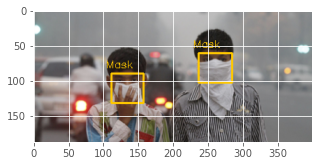

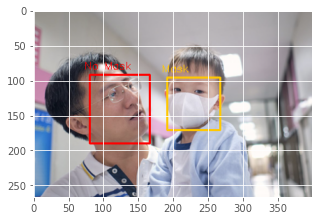

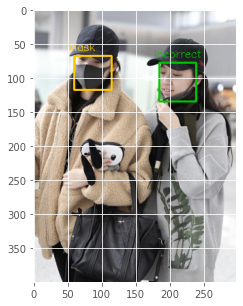

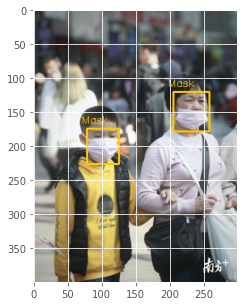

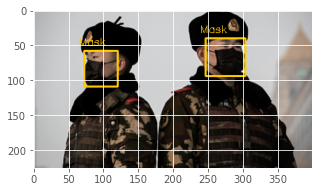

In [64]:
images_with_2=[]
for _ in ann_info['image_file'].value_counts().index:
    if ann_info[ann_info['image_file']==_].shape[0]==2:
        images_with_2.append(_)
for i in images_with_2[35:40]:
    render(os.path.join(images,i))

In [4]:
imgs = list(sorted(os.listdir("C:/Users/nehal/Downloads/FMD/images/")))
len(imgs)

853

In [5]:
labels = list(sorted(os.listdir("C:/Users/nehal/Downloads/FMD/annotations/")))

In [6]:
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("C:/Users/nehal/Downloads/FMD/images/", file_image)
    label_path = os.path.join("C:/Users/nehal/Downloads/FMD/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)

In [8]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
face_images=[]
face_labels=[]
for i in range(853):
    img_path = r"C:/Users/nehal/Downloads/FMD/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])
face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [9]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 717, 1: 3232, 2: 123}

In [10]:
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [11]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

In [12]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
    input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

9420800/9406464 [==============================] - 2s 0us/step


In [13]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [14]:
(trainX, testX, trainY, testY) = train_test_split(face_images, labels,
	test_size=0.2, stratify=labels, random_state=42)

In [22]:
test=aug.flow(trainX, trainY, batch_size=BS)

In [17]:
model.save('kaggle1.h5')

C:\Users\nehal\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [18]:
import keras
model = keras.models.load_model('kaggle1.h5')

In [19]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...


C:\Users\nehal\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
101/101 [==============================] - 57s 549ms/step - loss: 0.6407 - accuracy: 0.8909 - val_loss: 0.2830 - val_accuracy: 0.8920
Epoch 2/20
101/101 [==============================] - 56s 550ms/step - loss: 0.5665 - accuracy: 0.9064 - val_loss: 0.2954 - val_accuracy: 0.8847
Epoch 3/20
101/101 [==============================] - 58s 570ms/step - loss: 0.5833 - accuracy: 0.9023 - val_loss: 0.3296 - val_accuracy: 0.8724
Epoch 4/20
101/101 [==============================] - 57s 561ms/step - loss: 0.5381 - accuracy: 0.9091 - val_loss: 0.3193 - val_accuracy: 0.8748
Epoch 5/20
101/101 [==============================] - 57s 568ms/step - loss: 0.5608 - accuracy: 0.9054 - val_loss: 0.2942 - val_accuracy: 0.8810
Epoch 6/20
101/101 [==============================] - 58s 569ms/step - loss: 0.5642 - accuracy: 0.8967 - val_loss: 0.3303 - val_accuracy: 0.8613
Epoch 7/20
101/101 [==============================] - 58s 570ms/step - loss: 0.5562 - accuracy: 0.9064 - val_loss: 0.3814 - val_ac

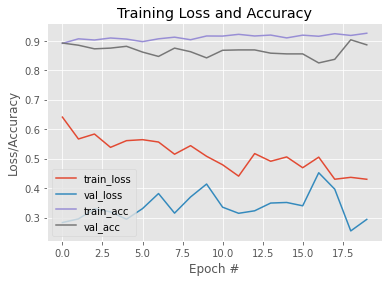

In [20]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


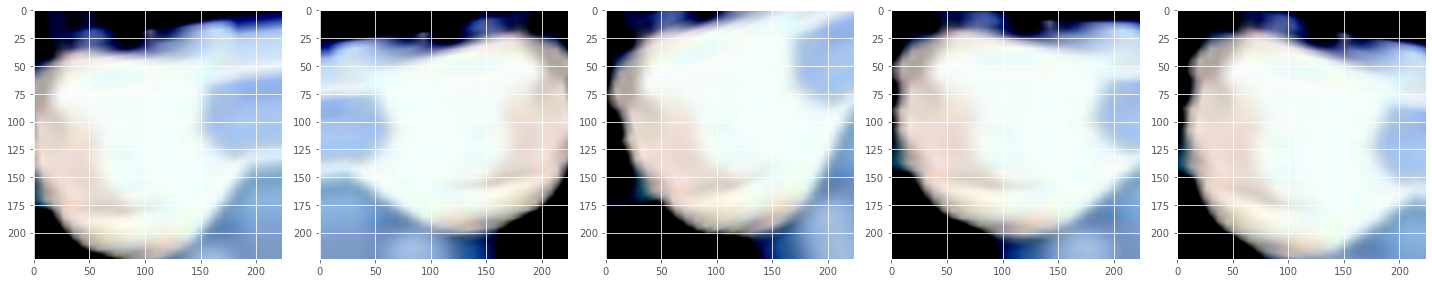

In [65]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    
    
augmented_images = [test[35][0][0] for i in range(5)]
plotImages(augmented_images)